In [2]:
#Define function to download and extract the housing data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
#Define function to import the housing data
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


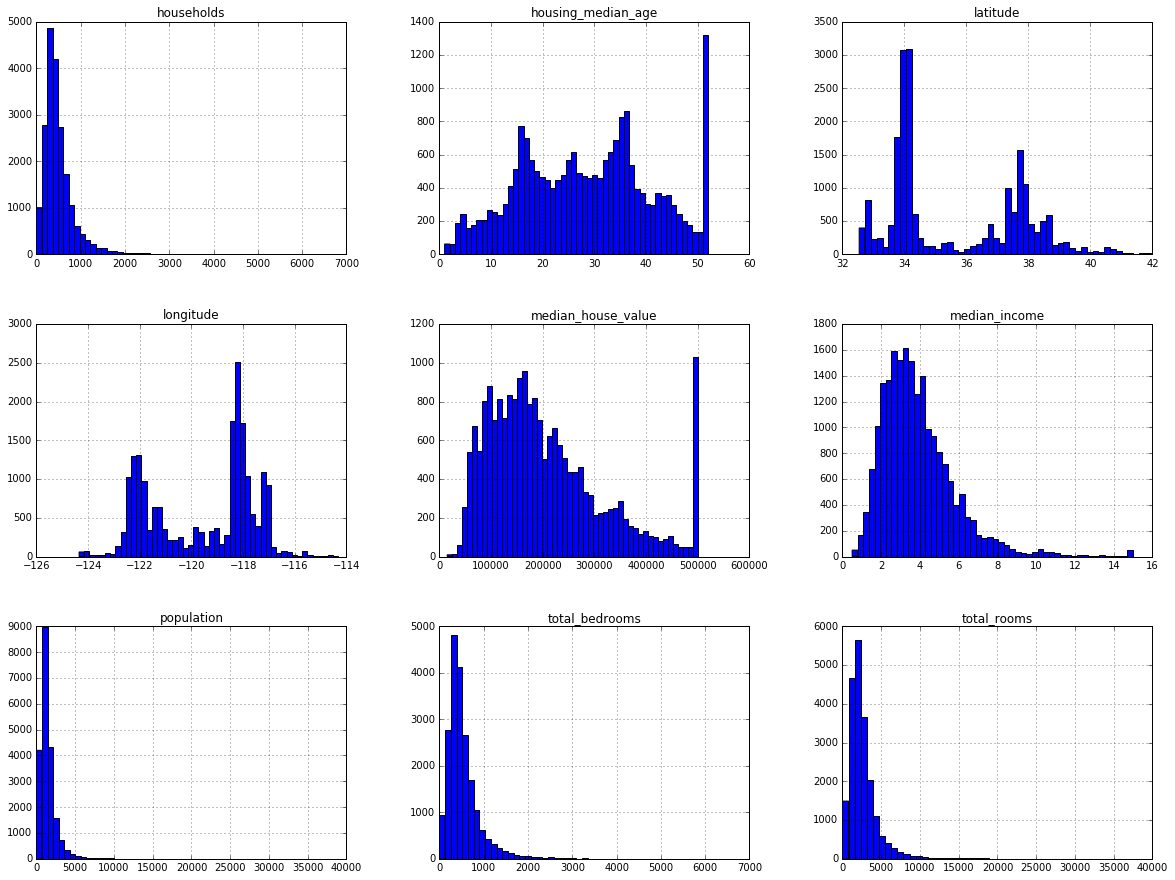

In [12]:
# Let's do some visual exploration
%matplotlib inline  
# The above command only works (and is needed) in a Jupyter Notebook
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [15]:
# Before we get any further, we need to seperate out our test set
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [16]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train + ", len(test_set), " test")

16512 train +  4128  test


The above method works, but will produce a different test/train set everytime
This is sub-optimal, as your algorithm will eventually see all the data, and your results
Won't match from time to time.

Solution 1: Set a seed before calling the permutation() function
np.random.seed(42)

...but what happens if the data changes?

Another option is to use a unique identifier to determine if any given row (observation) is in the test or train set. Then you simply take the total number of possible unique indentifiers, and split it with the same ratio as you want your test/train set to be.

One common option is to use the hash of the unique identifier. Then take the last byte (which will be between 0-256). Then split that range at the correct ratio. In our case 20% would be 51.


In [17]:
import hashlib

def test_set_check(indentifier, test_ratio, hash):
    return hash(np.int64(indentifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [20]:
# The housing data set doesn't have a unique identifier column, but
# we can add an index and use that
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [37]:
# Now, the entire reason we needed to do this was in case new data was later added,
# and the test/train split would come out different. But if new data isn't added to
# The end, then this new method will be broken as well. So we need to ensre this is true
# with the data source.

# We could alternatively create another unique field from a combination of fields that
# should, in most instances, be unique and static. In our case, we could use the lattitude
# and longitude fields.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")


In [34]:
# Scikit-Learn also has some built-in functions to do these sort of things for you
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [25]:
# Sometimes you want to make sure that the population of your test set is 
# representative of the general population. For instance, a poll of the US would
# want to make sure the number of males and females sampled were in proportion to the 
# greater population of the US. So if the US is 51.3% Female, the polling sample should
# be too.

# This is called "stratified sampling". And you first need to pick a field that you
# wish to ensure gets represented correctly. We can do this in Python using Scikit-Learn's
# StratifiedShuffleSplit module.

# First we need to pick a category. We pick median_income. But let's break it up into 5 
# categories. The original number is from 1-15. But the vast majority are less than 6.
# If we divide by 1.5, most will be below 4. We can then use ceil() to round up. We can
# then manually set anything greater than 5 to 5. This will result in 5 categories.
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)


In [26]:
housing["income_cat"].value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

In [27]:
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [28]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [29]:
# Now let's do the split, stratified...
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [31]:
#What was the original proportion?
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [32]:
# And the test set...
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [38]:
# Pretty good. But how did our purely random split turn out?
test_set["income_cat"] = np.ceil(test_set["median_income"] / 1.5)
test_set["income_cat"].where(test_set["income_cat"] < 5, 5.0, inplace=True)
test_set["income_cat"].value_counts() / len(test_set)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/eloy/.local/lib/python3.5/site-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


3.0    0.348273
2.0    0.310542
4.0    0.176538
5.0    0.129431
1.0    0.035216
Name: income_cat, dtype: float64

In [39]:
# Now you want to remove the 'income_cat' category, since it won't be used in 
# the actual training
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace = True)